In [196]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import fsolve
from scipy.optimize import minimize
from pyfinance import ols
import matplotlib.pyplot as plt

1

(a)

In [197]:
def call_delta(K,sigma,T,S0=100,r=0):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) \
             / (sigma * np.sqrt(T))
    return stats.norm.cdf(d1)

In [198]:
def put_delta(K,sigma,T,S0=100,r=0):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) \
             / (sigma * np.sqrt(T))
    return stats.norm.cdf(-d1)

In [199]:
put_par_list = [[0.1,0.3225],[0.25,0.2473],[0.4,0.2021],[0.5,0.1824]]

In [200]:
call_par_list = [[0.4,0.1574],[0.25,0.1370],[0.1,0.1148]]

In [201]:
call_strike = []
put_strike = []
for par in call_par_list:
        call_strike.append(fsolve(lambda x: call_delta(x, par[1], 1/12, 100, 0)-par[0],x0=100)[0])
for par in put_par_list:
        put_strike.append(fsolve(lambda x: put_delta(x, par[1], 1/12, 100, 0)-par[0],x0=100)[0])
strike_1m = put_strike + call_strike
sigma_1m = [i[1] for i in put_par_list + call_par_list]

In [202]:
put_par_list = [[0.1,0.2836],[0.25,0.2178],[0.4,0.1818],[0.5,0.1645]]

In [203]:
call_par_list = [[0.4,0.1462],[0.25,0.1256],[0.1,0.1094]]

In [204]:
call_strike = []
put_strike = []
for par in call_par_list:
        call_strike.append(fsolve(lambda x: call_delta(x, par[1], 3/12, 100, 0)-par[0],x0=100)[0])
for par in put_par_list:
        put_strike.append(fsolve(lambda x: put_delta(x, par[1], 3/12, 100, 0)-par[0],x0=100)[0])
strike_3m = put_strike + call_strike
sigma_3m = [i[1] for i in put_par_list + call_par_list]

In [205]:
K = {'1M': strike_1m, '3M': strike_3m}
strike = pd.DataFrame(K,index=['10DP','25DP','40DP','50D','40DC','25DC','10DC'])

In [206]:
strike

,1M,3M
10DP,89.138758,84.225674
25DP,95.542103,93.470685
40DP,98.700642,98.127960
50D,100.138720,100.338826
40DC,101.262273,102.141761
25DC,102.783751,104.532713
10DC,104.395838,107.422225


(b)

In [207]:
df = {'sigma1M':sigma_1m,'strike1M':strike_1m}
df = pd.DataFrame(df)

In [208]:
df

,sigma1M,strike1M
0,0.3225,89.138758
1,0.2473,95.542103
2,0.2021,98.700642
3,0.1824,100.138720
4,0.1574,101.262273
5,0.1370,102.783751
6,0.1148,104.395838


In [209]:
model = ols.OLS(y=df.sigma1M, x=df.strike1M)

In [210]:
alpha1m = model.alpha
beta1m = model.beta

In [211]:
beta1m

-0.013788352222217588

In [212]:
df = {'sigma3M':sigma_3m,'strike3M':strike_3m}
df = pd.DataFrame(df)

In [213]:
df

,sigma3M,strike3M
0,0.2836,84.225674
1,0.2178,93.470685
2,0.1818,98.127960
3,0.1645,100.338826
4,0.1462,102.141761
5,0.1256,104.532713
6,0.1094,107.422225


In [214]:
model = ols.OLS(y=df.sigma3M, x=df.strike3M)

In [215]:
alpha3m = model.alpha
beta3m = model.beta

In [216]:
beta3m

-0.007673547897915936

(c)

In [217]:
def call_price(K_list,vol_list,T,S0=100,r=0):
    i = 0
    c_list = []
    while i<len(K_list):
        d1 = (np.log(S0 / K_list[i]) + (r + 0.5 * vol_list[i] ** 2) * T) / (vol_list[i] * np.sqrt(T))
        d2 = d1 - vol_list[i] * np.sqrt(T)
        c_list.append(S0 * stats.norm.cdf(d1) - K_list[i] * np.exp(-r * T) * stats.norm.cdf(d2))
        i += 1
    return c_list

In [218]:
K_list = np.linspace(80,110,301)
vol_1M = alpha1m + beta1m*K_list
vol_3M = alpha3m + beta3m*K_list
c_1M = call_price(K_list,vol_1M,1/12)
c_3M = call_price(K_list,vol_3M,3/12)

In [219]:
j = 1
p_1M = []
p_3M = []
while j<len(c_1M)-1:
    p_1M.append((c_1M[j-1] -2*c_1M[j] + c_1M[j+1])/(0.01))
    p_3M.append((c_3M[j-1] -2*c_3M[j] + c_3M[j+1])/(0.01))
    j += 1

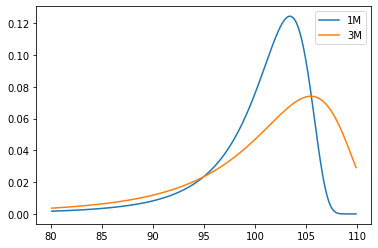

In [220]:
plt.plot(K_list[1:-1],p_1M,label='1M')
plt.plot(K_list[1:-1],p_3M,label='3M')
plt.legend()
plt.show()

(d)

In [221]:
K_list = np.linspace(70,130,601)
vol_1M = [0.1824 for i in range(len(K_list))]
vol_3M = [0.1645 for i in range(len(K_list))]
c_1M = call_price(K_list,vol_1M,1/12)
c_3M = call_price(K_list,vol_3M,3/12)

In [222]:
j = 1
p_1M = []
p_3M = []
while j<len(c_1M)-1:
    p_1M.append((c_1M[j-1] -2*c_1M[j] + c_1M[j+1])/(0.01))
    p_3M.append((c_3M[j-1] -2*c_3M[j] + c_3M[j+1])/(0.01))
    j += 1

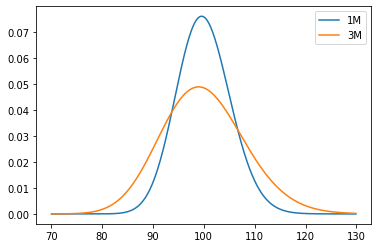

In [223]:
plt.plot(K_list[1:-1],p_1M,label='1M')
plt.plot(K_list[1:-1],p_3M,label='3M')
plt.legend()
plt.show()

(d)

In [224]:
K_list = np.linspace(80,140,601)
vol_1M = alpha1m + beta1m*K_list
c_1M = call_price(K_list,vol_1M,1/12)

In [225]:
j = 1
d_1M = []
while j<len(c_1M)-1:
    d_1M.append((c_1M[j-1] -2*c_1M[j] + c_1M[j+1])/(0.01))
    j += 1

In [226]:
def digital_put(K,K_list,d_list,w):
    i = 0
    price = 0
    while i < len(d_list):
        if K_list[i] > K:
            price += 0
        else:
            price += 1*d_list[i]*w
        i += 1
    return price

In [227]:
def digital_call(K,K_list,d_list,w):
    i = 0
    price = 0
    while i < len(d_list):
        if K_list[i] < K:
            price += 0
        else:
            price += 1*d_list[i]*w
        i += 1
    return price

In [228]:
digital_put(110,K_list[1:-1],d_1M,0.1)

0.9822320264947844

In [229]:
K_list = np.linspace(90,120,601)
vol_3M = alpha3m + beta3m*K_list
c_3M = call_price(K_list,vol_3M,3/12)

In [230]:
j = 1
d_3M = []
while j<len(c_3M)-1:
    d_3M.append((c_3M[j-1] -2*c_3M[j] + c_3M[j+1])/(0.01))
    j += 1

In [231]:
digital_call(105,K_list[1:-1],d_3M,0.2)

0.3292756110096208

In [232]:
def call(K,K_list,d_list,w):
    i = 0
    price = 0
    while i < len(d_list):
        price += np.maximum(K_list[i]-K,0)*d_list[i]*w
        i += 1
    return price

In [233]:
K_list = np.linspace(80,140,601)
vol_1M = alpha1m + beta1m*K_list
c_1M = call_price(K_list,vol_1M,1/12)
j = 1
d_1M = []
while j<len(c_1M)-1:
    d_1M.append((c_1M[j-1] -2*c_1M[j] + c_1M[j+1])/(0.01))
    j += 1
    
K_list = np.linspace(80,140,601)
vol_3M = alpha3m + beta3m*K_list
c_3M = call_price(K_list,vol_3M,3/12)
j = 1
d_3M = []
while j<len(c_3M)-1:
    d_3M.append((c_3M[j-1] -2*c_3M[j] + c_3M[j+1])/(0.01))
    j += 1

d_2M = [0.5*d_1M[i]+0.5*d_3M[i] for i in range(len(d_1M))]

In [234]:
call(100,K_list[1:-1],d_2M,0.1)

2.662407380974223

2

(a)

In [235]:
def characteristic_function(u,t,sigma=0.2,v0=0.08,k=0.7,rho=-0.4,theta=0.1,r=0.02,S0=250,q=0):
    Lambda = np.sqrt((sigma ** 2) * (complex(u ** 2, u)) + (complex(k, -rho * sigma * u)) ** 2)
    omega = np.exp(complex(0, u * (np.log(S0) + (r - q) * t)) + k * theta * t * complex(k, -rho * sigma * u) / sigma ** 2) \
            / (np.cosh(Lambda * t / 2) + (complex(k, -rho * sigma * u) / Lambda) * np.sinh(Lambda * t / 2)) ** (2 * k * theta / sigma ** 2)
    phi = omega * np.exp(-(complex(u ** 2, u)) * v0 / (Lambda / np.tanh(Lambda * t / 2) + complex(k, -rho * sigma * u)))
    return phi

In [236]:
def fft(K=250, n=10, alpha=1, UB=500, t=0.5,sigma=0.2, v0=0.08, k=.7, rho=-0.4, theta=0.1,r = 0.015,q = 0.0177,S0 = 267.15):
    N = 2 ** n
    B = UB

    v = np.linspace(0, B, N + 1)[0:-1]
    delta_v = B / N

    delta_k = 2 * np.pi / B
    beta = np.log(S0) - delta_k * N / 2
    km = beta + (np.linspace(0, N, N + 1)[0:-1]) * delta_k
    
    x = []
    for j in range(N):
        if j == 0:
            wj = 0.5
        else:
            wj = 1

        phi = characteristic_function(complex(v[j], -(alpha + 1)), t, sigma, v0, k, rho, theta, r, S0, q)
        xj = phi * np.exp(complex(0, -beta) * v[j]) * wj * delta_v / \
             (complex(alpha, v[j])) / complex(alpha + 1, v[j])
        x.append(xj)
    x = np.array(x) * np.exp(-r * t)
    y = np.fft.fft(x)

    call_price = []
    for j in range(N):
        c = np.exp(-alpha * (np.log(S0) - delta_k * (N / 2 - j))) * np.real(y[j]) / np.pi
        call_price.append(c)
    
    
    return np.exp(km), call_price

In [237]:
def call_price(sigma, v0, k, rho, theta,K=250,n=10,alpha=1,UB=600,t=0.5,r = 0.015,q = 0.0177,S0 = 267.15):
    K_list, price_list = fft(K,n,alpha,UB,t,sigma, v0, k, rho, theta,r,q,S0)
    return np.interp(K, K_list, price_list)

In [238]:
data = pd.read_excel('mf796-hw5-opt-data.xlsx')

In [239]:
def strictly_increasing(L):
    return all(x<y for x, y in zip(L, L[1:]))

In [240]:
def strictly_increasing(L):
    return all(x<y for x, y in zip(L, L[1:]))

def strictly_decreasing(L):
    return all(x>y for x, y in zip(L, L[1:]))

def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))

def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def monotonic(L):
    return non_increasing(L) or non_decreasing(L)

In [241]:
print(data.groupby(['expDays']).call_bid.apply(monotonic))
print(data.groupby(['expDays']).call_ask.apply(monotonic))
print(data.groupby(['expDays']).put_bid.apply(monotonic))
print(data.groupby(['expDays']).put_ask.apply(monotonic))

expDays
49     True
140    True
203    True
Name: call_bid, dtype: bool
expDays
49     True
140    True
203    True
Name: call_ask, dtype: bool
expDays
49     True
140    True
203    True
Name: put_bid, dtype: bool
expDays
49     True
140    True
203    True
Name: put_ask, dtype: bool


In [242]:
def call_rate_change(L):
    return all( x>=1 or x<=0 for x in (L/L.shift(1) - 1).fillna(0))

def put_rate_change(L):
    return all( x>=0 or x<=-1 for x in (L/L.shift(1) - 1).fillna(0))

In [243]:
print(data.groupby(['expDays']).call_bid.apply(call_rate_change))
print(data.groupby(['expDays']).call_ask.apply(call_rate_change))
print(data.groupby(['expDays']).put_bid.apply(put_rate_change))
print(data.groupby(['expDays']).put_ask.apply(put_rate_change))

expDays
49     True
140    True
203    True
Name: call_bid, dtype: bool
expDays
49     True
140    True
203    True
Name: call_ask, dtype: bool
expDays
49     True
140    True
203    True
Name: put_bid, dtype: bool
expDays
49     True
140    True
203    True
Name: put_ask, dtype: bool


In [244]:
def convex(L):
    return all( x>=0 for x in (((L.shift(-1) + L.shift(1))/2 - L).dropna()))

In [245]:
print(data.groupby(['expDays']).call_bid.apply(convex))
print(data.groupby(['expDays']).call_ask.apply(convex))
print(data.groupby(['expDays']).put_bid.apply(convex))
print(data.groupby(['expDays']).put_ask.apply(convex))

expDays
49     True
140    True
203    True
Name: call_bid, dtype: bool
expDays
49     True
140    True
203    True
Name: call_ask, dtype: bool
expDays
49     True
140    True
203    True
Name: put_bid, dtype: bool
expDays
49     True
140    True
203    True
Name: put_ask, dtype: bool


In [246]:
def optimizer(sigma, v0, k, rho, theta,dataset):
    T = np.unique(data.expT)
    sse = 0
    for t in T:
        K = data.K[data.expT == t]
        c = data.call_mid[data.expT==t]
        K_list,c_list = fft(sigma=sigma,v0=v0,k=k,rho=rho,theta=theta,t=t)
        sse += np.sum((np.interp(K, K_list, c_list) - c.tolist())**2)
    print(sse)
    return sse

In [247]:
# def optimizer(sigma, v0, k, rho, theta,dataset):
#     i = 0
#     sse = 0
#     while i< dataset.shape[0]:
#         T = dataset.expT[i]
#         strike = dataset.K[i]
#         c1 = call_price(sigma, v0, k, rho, theta,K=strike,n=10,alpha=1,UB=600,t=T)
#         c = dataset.call_mid[i]
#         sse += (c1 - c)**2
#         i = i + 1
#     print(sse)
#     return sse

In [248]:
data['call_mid']  = (data['call_bid'] + data['call_ask'])/2

In [249]:
data

,expDays,expT,K,call_bid,call_ask,put_bid,put_ask,call_mid
0,49,0.134155,240,29.52,29.74,1.52,1.54,29.630
1,49,0.134155,245,24.87,25.09,1.89,1.91,24.980
2,49,0.134155,250,20.36,20.55,2.38,2.40,20.455
3,49,0.134155,255,16.02,16.19,3.03,3.07,16.105
4,49,0.134155,260,11.95,12.08,3.94,3.98,12.015
5,49,0.134155,265,8.27,8.33,5.24,5.28,8.300
6,49,0.134155,270,5.10,5.16,7.08,7.14,5.130
7,49,0.134155,275,2.71,2.74,9.67,9.82,2.725
8,49,0.134155,280,1.22,1.24,13.25,13.49,1.230
9,140,0.383299,220,50.04,50.31,2.44,2.46,50.175


In [250]:
x0 = [2,0.2,0.5,-1,0.1]
bnds = ((0.01, 5), (0, 2),(0,1),(-1,1),(0,1))
args = minimize(lambda p: optimizer(p[0],p[1],p[2],p[3],p[4],data),x0,method='SLSQP',bounds=bnds)

1693.1550540955081
1693.1550540955081
1693.155023924076
1693.1554600712323
1693.1550536326208
1693.155079176845
1693.1551102502867
1914.3232943617145
476.6009757329722
476.6009757329722
476.6009789489235
476.6008810766639
476.6009740494185
476.60094163235624
476.6009410044548
3158.340312570593


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in tanh
  """


152.7435044487156
152.7435044487156
152.74350604060282
152.74342773602672
152.74350143136562
152.74350407268557
152.7434802766248
77836.08052897094
2472.4931939018397
81.76050455897274
81.76050455897274
81.76050433020967
81.76052285079659
81.76050455114652
81.76050835398405
81.76050553465828
1953.3201832857544
66.6277579079674
66.6277579079674
66.62775783042565
66.62776911018874
66.62775781387711
66.62776129048356
66.62775799138771
1953.320169871107
50.17499997899475
50.17499997899475
50.17499997461035
50.175008156997635
50.17499976408536
50.17500280377287
50.174999602034305


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in cdouble_scalars
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in cdouble_scalars
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


nan
37.36170976195455
37.36170976195455
37.36170951137095
37.361726343636654
37.361710271665586
37.36171275050599
37.36171185292443
1953.3201818713255
26.333535361938885
26.333535361938885
26.33353534338612
26.333542630853266
26.333535370436078
26.33353742675616
26.333535624975994
nan
20.661505607339706
20.661505607339706
20.661505632845902
20.661510538928486
20.661505558785738
20.66150738038162
20.661505685508832
771.3824737763471
16.37309629814449
16.37309629814449
16.373096309460816
16.37310308277081
16.373096240623
16.373097610138295
16.373096357296873
nan
11.830051647757472
11.830051647757472
11.830051502719787
11.830062491269135
11.830052124367867
11.830052964306116
11.830052823783967
794.7596079165336
8.722650905889154
8.722650905889154
8.72265090645778
8.722655856238937
8.72265102402083
8.72265185052353
8.722651242954344
285.7072346288964
6.963764085153778
6.963764085153778
6.963764085164611
6.963768265600882
6.963764204062468
6.963764974760444
6.963764378242284
61.727557531452

In [251]:
args

     fun: 1.4357456095554524
     jac: array([ 2.51248479e-04,  8.38283747e-02, -6.30502447e-01,  7.16850162e-04,
        1.29875094e-02])
 message: 'Optimization terminated successfully.'
    nfev: 432
     nit: 58
    njev: 58
  status: 0
 success: True
       x: array([ 1.31685057,  0.04098991,  1.        , -0.79970486,  0.13490424])

In [115]:
x0 = [2,0.2,0.5,-1,0.1]
bnds = ((0.01, 2.5), (0, 1),(0,1),(-1,0.5),(0,0.5))
args = minimize(lambda p: optimizer(p[0],p[1],p[2],p[3],p[4],data),x0,method='SLSQP',bounds=bnds)

0.13415468856947296
0.38329911019849416
0.5557837097878165
1693.1550540955081
0.13415468856947296
0.38329911019849416
0.5557837097878165
1693.1550540955081
0.13415468856947296
0.38329911019849416
0.5557837097878165
1693.155023924076
0.13415468856947296
0.38329911019849416
0.5557837097878165
1693.1554600712323
0.13415468856947296
0.38329911019849416
0.5557837097878165
1693.1550536326208
0.13415468856947296
0.38329911019849416
0.5557837097878165
1693.155079176845
0.13415468856947296
0.38329911019849416
0.5557837097878165
1693.1551102502867
0.13415468856947296
0.38329911019849416
0.5557837097878165
1900.07701863853
0.13415468856947296
0.38329911019849416
0.5557837097878165
236.05002566310637
0.13415468856947296
0.38329911019849416
0.5557837097878165
236.05002566310637
0.13415468856947296
0.38329911019849416
0.5557837097878165
236.05002767208086
0.13415468856947296
0.38329911019849416
0.5557837097878165
236.05000471669115
0.13415468856947296
0.38329911019849416
0.5557837097878165
236.05002

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in cdouble_scalars
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in cdouble_scalars
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


0.38329911019849416
0.5557837097878165
nan
0.13415468856947296
0.38329911019849416
0.5557837097878165
695.3794542261214
0.13415468856947296
0.38329911019849416
0.5557837097878165
62.78262821097636
0.13415468856947296
0.38329911019849416
0.5557837097878165
62.78262821097636
0.13415468856947296
0.38329911019849416
0.5557837097878165
62.782628516100466
0.13415468856947296
0.38329911019849416
0.5557837097878165
62.782629160441026
0.13415468856947296
0.38329911019849416
0.5557837097878165
62.78262798809207
0.13415468856947296
0.38329911019849416
0.5557837097878165
62.782630189343806
0.13415468856947296
0.38329911019849416
0.5557837097878165
62.782621953381614
0.13415468856947296
0.38329911019849416
0.5557837097878165
142.47694004372954
0.13415468856947296
0.38329911019849416
0.5557837097878165
20.167550194209195
0.13415468856947296
0.38329911019849416
0.5557837097878165
20.167550194209195
0.13415468856947296
0.38329911019849416
0.5557837097878165
20.16754999871621
0.13415468856947296
0.3832

0.38329911019849416
0.5557837097878165
1.6768248833783896
0.13415468856947296
0.38329911019849416
0.5557837097878165
1.6770090519172411
0.13415468856947296
0.38329911019849416
0.5557837097878165
1.6563413764913535
0.13415468856947296
0.38329911019849416
0.5557837097878165
1.6563413764913535
0.13415468856947296
0.38329911019849416
0.5557837097878165
1.656341398678212
0.13415468856947296
0.38329911019849416
0.5557837097878165
1.6563408914023858
0.13415468856947296
0.38329911019849416
0.5557837097878165
1.6563413316396254
0.13415468856947296
0.38329911019849416
0.5557837097878165
1.6563413439982275
0.13415468856947296
0.38329911019849416
0.5557837097878165
1.6563412101644386
0.13415468856947296
0.38329911019849416
0.5557837097878165
1.6505797048612851
0.13415468856947296
0.38329911019849416
0.5557837097878165
1.6505797048612851
0.13415468856947296
0.38329911019849416
0.5557837097878165
1.6505797759714909
0.13415468856947296
0.38329911019849416
0.5557837097878165
1.650577807489497
0.134154

In [60]:
args

     fun: 1.4437161259614482
     jac: array([-0.00089446,  0.00514826, -0.62739475, -0.0023507 ,  0.00204484])
 message: 'Optimization terminated successfully.'
    nfev: 217
     nit: 29
    njev: 29
  status: 0
 success: True
       x: array([ 1.31073329,  0.04097377,  1.        , -0.79972359,  0.13428111])

In [42]:
x0 = [0.5,0.2,0.2,0,0.2]
bnds = ((0.01, 5), (0.01, 2),(0,2),(-1,1),(0,1))
args = minimize(lambda p: optimizer(p[0],p[1],p[2],p[3],p[4],data),x0,method='SLSQP',bounds=bnds)

9419.917026940524
9419.917026940524
9419.916984622609
9419.918278596964
9419.91703102272
9419.917039037433
9419.917087420228
1200.1484662604787
1200.1484662604787
1200.1484682723935
1200.1483137313026
1200.1484666317515
1200.1484201420387
1200.1484662481644
2374.0889547916686


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in tanh
  """
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in cdouble_scalars
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in cdouble_scalars
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in cosh
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in sinh
  after removing the cwd from sys.path.


nan
1062.317944290194
1062.317944290194
1062.3179464208001
1062.317771427246
1062.3179449958895
1062.3179222805313
1062.3179442780129
41749.87435099027
4060.8155815965183
170.02473569293335
170.02473569293335
170.0247364922493
170.02471654525118
170.0247360784782
170.02472626938828
170.02473569021433
6011.8381395108845
152.1102857247497
152.1102857247497
152.11028593116282
152.11028688985587
152.11028484464737
152.1102794974591
152.1102857232469


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


nan
157.57288899919712
146.06295571279543
146.06295571279543
146.06295544226347
146.06297137199576
146.06295492855887
146.0629516696462
146.06295531097382
1590.2076386427377
142.18236496542553
142.18236496542553
142.18236428243034
142.18239219137683
142.18236453781017
142.18236330871486
142.18236489098877
nan
128.8821224259214
128.8821224259214
128.8821218574171
128.88214735319823
128.88212194838025
128.88212195524414
128.88212228321288
772.7295170824151
116.01391970754217
116.01391970754217
116.01391909712765
116.01394730241213
116.01391933222625
116.01391981953456
116.01391966006791
693.9390107722353
103.21922781378838
103.21922781378838
103.21922728236164
103.21925448521439
103.2192273502444
103.21922802444404
103.21922771546078
555.7767106935614
90.40337642734822
90.40337642734822
90.40337601265207
90.40340091639817
90.40337580092631
90.40337664178085
90.40337624215535
412.33918625243194
75.33938252616828
75.33938252616828
75.33938227767824
75.33940331815079
75.33938163685107
75.33

1.3356389119935206
1.3356407152630072
1.3356389949978733
1.3356389872285541
1.3356395925273654
49.31613313117449
1.2842103805245009
1.2842103805245009
1.284210408377371
1.2842098878026802
1.2842103516751397
1.2842103188465601
1.2842100578050941
1.2808391909122785
1.2728886855397228
1.2728886855397228
1.272888744231943
1.2728871838298768
1.2728886338564647
1.2728885996905732
1.2728879441038545
1.246677121438548
1.246677121438548
1.2466771652008977
1.2466757352992894
1.2466770839843302
1.246677088081405
1.2466765888238749
1.2252819884280188
1.2252819884280188
1.2252820270569902
1.2252805853627435
1.2252819577251102
1.2252819699509798
1.2252815410149802
1.1921670062974714
1.1921670062974714
1.1921670494354006
1.1921654019907681
1.1921669748478643
1.1921669820684917
1.192166481832661
1.1292086515243605
1.1292086515243605
1.1292086688124923
1.1292078498446587
1.129208640623076
1.129208646120608
1.129208537342812
1.6042695161658223
1.1202568946466291
1.1202568946466291
1.1202569269699818
1.1

In [267]:
args

     fun: 5.793575558827051e-05
     jac: array([5.20491494e-05, 4.68721623e-04, 1.82194594e-05, 2.56053640e-05,
       1.21197354e-04])
 message: 'Optimization terminated successfully.'
    nfev: 113
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([ 1.98179482,  0.04729178,  0.56118986, -0.78117345,  0.30373653])

In [275]:
def weighted_optimizer(sigma, v0, k, rho, theta,dataset):
    T = np.unique(data.expT)
    sse = 0
    for t in T:
        K = data.K[data.expT == t]
        c = data.call_mid[data.expT==t]
        w = 1/(dataset.call_ask[data.expT==t] - dataset.call_bid[data.expT==t])
        K_list,c_list = fft(sigma=sigma,v0=v0,k=k,rho=rho,theta=theta,t=t)
        sse += np.sum(w.tolist()*((np.interp(K, K_list, c_list)-c.tolist())**2))
    print(sse)
    return sse/10

In [118]:
# def weighted_optimizer(sigma, v0, k, rho, theta,dataset):
#     i = 0
#     sse = 0
#     while i< dataset.shape[0]:
#         T = dataset.expT[i]
#         strike = dataset.K[i]
#         w = 1/(dataset.call_ask[i] - dataset.call_bid[i])
#         c1 = call_price(sigma, v0, k, rho, theta,K=strike,n=10,alpha=1,UB=600,t=T)
#         c = dataset.call_mid[i]
#         sse += w*(c1 - c)**2
#         i = i + 1
#     print(sse)
#     return sse

In [283]:
x0 = [2,0.2,0.5,-1,0.1]
bnds = ((0.01, 2.5), (0, 1),(0,1),(-2,0.5),(0,0.5))
args = minimize(lambda p: weighted_optimizer(p[0],p[1],p[2],p[3],p[4],data),x0,method='SLSQP',bounds=bnds)

14758.902555878802
14758.902555878802
14758.90227149746
14758.90628667214
14758.902560081231
14758.902866357457
14758.90299953863
15488.234348009793
7570.349238041444
7570.349238041444
7570.349274955844
7570.348466946658
7570.349209323706
7570.349172334974
7570.349087647224
5608.400644420276
5608.400644420276
5608.40057302238
5608.402351615789
5608.400950380782
5608.40083386931
5608.401320643533


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in cdouble_scalars
  """
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in cdouble_scalars
  """
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


nan
3105.1793671285436
3105.1793671285436
3105.17930496774
3105.1807671896395
3105.1795882237434
3105.1795259888713
3105.1798584707167
56029.61818266341
1690.5817608742123
1690.5817608742123
1690.581716030565
1690.5825726654878
1690.5819112526326
1690.5818733652543
1690.5820963760834
5085.511130669868
3831.6985343776405
974.973201379268
974.973201379268
974.9731748120437
974.9737422744323
974.973272637754
974.973201522067
974.97337573811
19072.17516789372
762.4192713998159
762.4192713998159
762.4192385588071
762.4200787100378
762.4193514720289
762.4193556737741
762.4194677453131
1937.4201933354552
219.02796837792624
219.02796837792624
219.02795918838706
219.0281907446925
219.0279968631476
219.02800526456798
219.0280563701893
3040.0101034474847
114.85437425317186
114.85437425317186
114.85437221308422
114.85438893417938
114.85438239976452
114.85439170604279
114.8544034130871
2401.5983893474704
86.56237555995921
86.56237555995921
86.56237137716322
86.56252801056712
86.56238647985958
86.56

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in cdouble_scalars
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in cdouble_scalars
  after removing the cwd from sys.path.



37.481966387300744
37.481966387300744
37.48196501057633
37.48202714973668
37.48196961554606
37.48197578330414
37.481981735671376
1885.7965658334429
25.09787570372255
25.09787570372255
25.097876362739925
25.097874478879774
25.097875402187498
25.09787954194558
25.09787577915065
nan
18.796043546956287
18.796043546956287
18.796042920899026
18.796069334731886
18.796044768719465
18.796049257125436
18.79605093505208
14.448888717931922
14.448888717931922
14.448888077210487
14.448895816928548
14.44888839810099
14.44889046703692
14.448885681284011
11.403811813065161
11.403811813065161
11.403813273439454
11.403785096117689
11.403810297838776
11.403809249619904
11.403802929155976
11.193293235853169
10.535123459748009
10.535123459748009
10.53512354302555
10.535125582670995
10.535123454914283
10.53512360183208
10.535124149833667
10.202789230287816
10.202789230287816
10.20278928424572
10.202786123928172
10.202789121865544
10.202789341785127
10.202788990736313
10.193827163646676
10.193827163646676
10

In [284]:
sse = args.fun*10
result = args.x
print(sse)
print(result)

9.266323914065818
[ 1.21704368  0.03957368  1.         -0.81469104  0.1306994 ]


In [272]:
x0 = [2,0.2,0.5,-1,0.1]
bnds = ((0.01, 5), (0, 2),(0,1),(-1,1),(0,1))
args = minimize(lambda p: weighted_optimizer(p[0],p[1],p[2],p[3],p[4],data),x0,method='SLSQP',bounds=bnds)

14758.902555878802
14758.902555878802
14758.90227149746
14758.90628667214
14758.902560081231
14758.902866357457
14758.90299953863
15488.234348009793
5802.976767633945
5802.976767633945
5802.976797026178
5802.975793000856
5802.976752059578
5802.976236672558
5802.976662136636
15488.214382501765


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in tanh
  """


4193.614551273897
2853.1799375570886
2853.1799375570886
2853.1799577589727
2853.178809117503
2853.179929439096
2853.179879543387
2853.179753021687


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in cdouble_scalars
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in cdouble_scalars
  after removing the cwd from sys.path.


nan
31751.792726705724
1216.250544083321
1216.250544083321
1216.250548441802
1216.2504853325502
1216.2505389959397
1216.2505639729798
1216.250491199156
30626.51830834894
918.0851430115877
918.0851430115877
918.0851452989027
918.0851804618321
918.0851329746661
918.0851735211752
918.0851091291997
nan
731.8966312793426
731.8966312793426
731.8966298339966
731.8968230704224
731.8966279731367
731.896675577786
731.8966260156292
15488.234304474361
564.677703958049
564.677703958049
564.6777046343593
564.6777965418896
564.6776972324735
564.6777391989988
564.6776931312761
nan
421.9915701660446
421.9915701660446
421.99157054616023
421.9916704249151
421.991564664766
421.9916014396318
421.9915630339026
nan
331.9516270439291
331.9516270439291
331.95162637648355
331.95175762397014
331.95162626919625
331.95165924925027
331.9516278192359
3140.870472679976
202.00371214057242
202.00371214057242
202.00371343020623
202.0037636361904
202.0037057338816
202.00373024184535
202.00370550466303
nan
150.75584621336

KeyboardInterrupt: 

In [280]:
sse = args.fun*10
result = args.x
print(sse)
print(result)

9.266323914065818
[ 1.21704368  0.03957368  1.         -0.81469104  0.1306994 ]


In [281]:
x0 = [0.5,0.2,0.2,0,0.2]
bnds = ((0.01, 5), (0.01, 2),(0,2),(-1,1),(0,1))
args = minimize(lambda p: weighted_optimizer(p[0],p[1],p[2],p[3],p[4],data),x0,method='SLSQP',bounds=bnds)

115192.1299903484
115192.1299903484
115192.12953085269
115192.14416291137
115192.13003344752
115192.13026285598
115192.13063542411
8395.185254775419
8395.185254775419
8395.185174634107
8395.186426344377
8395.185231530944
8395.185493226687
8395.18525500567
14709.371255407757
3738.037531329139
3738.037531329139
3738.0375414631726
3738.0373184001114
3738.0375307691493
3738.037144128945
3738.0373874841034


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in tanh
  """


91984.93050858441
1965.082360681624
1965.082360681624
1965.08236655572
1965.082282658559
1965.0823509716483
1965.0821266310766
1965.082258042925
54293.85782845196
1337.0668272646176
1337.0668272646176
1337.066829590657
1337.066850809672
1337.0668168733844
1337.0666530157855
1337.0667693093064
13670.551670165305
691.6136974883343
691.6136974883343
691.6137011438145
691.6136700700997
691.6136883659816
691.6136319388418
691.6136180745805
28216.432626095324
435.00906869258404
435.00906869258404
435.00906754724565
435.0091665912048
435.00906675085326
435.00904667363034
435.00906150599644
1056.612546923509
257.0342097264754
257.0342097264754
257.0342093479871
257.03424836167045
257.0342103516342
257.0341818672388
257.0342178822572
13035.709826983832
210.8006051069092
210.8006051069092
210.80060581545234
210.80061087102467
210.80060355932414
210.8005811845279
210.80059999864812
870.6992325458995
189.93814752849784
189.93814752849784
189.93814271696522
189.93829621964682
189.93815775082396
189

8.433652445924428
8.433664738787543
8.43366434897801
8.433660007320857
8.110087293767005
8.110087293767005
8.110087359199893
8.110084916526395
8.110087218797783
8.110087125554553
8.110086861168668
10.624129086882913
8.03477074568677
8.03477074568677
8.03477092884695
8.034765319182688
8.034770593053771
8.034770393743747
8.034768963305702
9.13211201722226
7.9334923067718695
7.9334923067718695
7.933492611777122
7.93348380696932
7.933492078120803
7.933491770338959
7.933489047261433
7.954529333671835
7.808841647364694
7.808841647364694
7.808842168405617
7.808827842072695
7.808841290707671
7.808840789713443
7.808835583958487
7.645108511808672
7.645108511808672
7.645109008547472
7.645095848220689
7.645108183731017
7.645107765543177
7.645102652334887
7.381464810014377
7.381464810014377
7.381464921042555
7.381462721719552
7.381464733756037
7.3814647948543435
7.381464220310072
8.236528357887122
7.287427951764162
7.287427951764162
7.287428210424462
7.287422145053089
7.287427790386314
7.2874276677

In [282]:
sse = args.fun*10
result = args.x
print(sse)
print(result)

6.519457392825493
[ 1.45906754  0.04279818  2.         -0.81113807  0.08928096]


3

(a)

In [67]:
k = 3.51
theta = 0.052
sigma = 1.17
rho = -0.77
v0 = 0.034
S0 = 267.15
r = 0.015
q = 0.0177
T = 0.25
K = 275
alpha = 1
n = 15
UB = 1000

In [68]:
c0 = call_price(sigma, v0, k, rho, theta,K,n,alpha,UB,T,r,q,S0)

In [69]:
cplus = call_price(sigma, v0, k, rho, theta,K,n,alpha,UB,T,r,q,S0+2)
cminus = call_price(sigma, v0, k, rho, theta,K,n,alpha,UB,T,r,q,S0-2)

In [70]:
delta = (cplus-cminus)/4

In [71]:
delta

0.4762603833210668

In [72]:
def bsm_call_value(s0, k, t, r, sigma):
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    d2 = (np.log(s0 / k) + (r - 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    value = (s0 * stats.norm.cdf(d1) - k * np.exp(-r * t) * stats.norm.cdf(d2))
    # print('cvalue',value)
    return value

In [73]:
implied_vol = fsolve(lambda x: bsm_call_value(S0,K , T, r, x)-c0,x0=0.5)[0]

In [74]:
bsm_delta =call_delta(K,implied_vol,T,S0,r)

In [75]:
bsm_delta

0.36687192939578234

(b)

In [96]:
cplus1 = call_price(sigma, v0+0.01, k, rho, theta+0.01,K,n,alpha,UB,T,r,q,S0)
cminus1 = call_price(sigma, v0-0.01, k, rho, theta-0.01,K,n,alpha,UB,T,r,q,S0)

In [97]:
Vega = (cplus1-cminus1)/0.02

In [98]:
Vega

131.82303086316568

$$
\frac{\partial C}{\partial \sigma}=S_{t} N'\left(d_{1}\right) \sqrt{T-t}
$$

In [99]:
def call_vega(K,sigma,T,S0=100,r=0):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) \
             / (sigma * np.sqrt(T))
    return S0*stats.norm.pdf(d1)*np.sqrt(T)

In [100]:
bsm_vega = call_vega(K,implied_vol,T,S0,r)

In [101]:
bsm_vega

50.293392366377915